In [162]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%load_ext autoreload
import os
from toolsets.search import quick_search_values, string_search
%autoreload 2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
pd.options.mode.chained_assignment = None  # default='warn'
from rdkit.Chem import rdFMCS
from rdkit import Chem
from tqdm import tqdm
def serrf_norm(data_working, compound_list, qc_idx):
    data_normalized = data_working.copy()
    for compound in tqdm(compound_list):
        rf_temp = build_qc_model(data_working, qc_idx, col_name=compound)
        predicted = make_predictions(rf_temp, x= data_working.drop(columns = compound), y_raw=data_working[compound])
    data_normalized[compound]=predicted
    data_normalized[data_normalized<0]=0
    return(data_normalized)
def cv_plot(raw_data, compound_name, qc_idx= None, savepath = None):
    # print(qc_idx is None)
    if 'sampleType' in raw_data.columns:
        qc_data = string_search(raw_data, 'sampleType', 'qc')
    elif qc_idx is not None:
        # print(qc_idx is None == False)
        qc_data = raw_data[qc_idx]
    else:
        print('no qc info provided')
        return()
    fig, ax = plt.subplots()
    sns.scatterplot(x =  raw_data['time'], y = raw_data[compound_name])
    sns.scatterplot(x =  qc_data['time'], y = qc_data[compound_name], color='red')
    plt.xticks([])
    plt.title(compound_name)
    # plt.show()
    if savepath is not None:
        plt.savefig(savepath)
    else:
        plt.show()
    return(calc_cv(raw_data[compound_name]), calc_cv(qc_data[compound_name]))
    # print('the cv overall is: ', calc_cv(raw_data[compound_name]))
    # print('the cv on qc is: ', calc_cv(qc_data[compound_name]))
def autoscale(col):
    scaled = []
    for item in col:
        scaled.append((item-col.mean())/col.std())
    return  scaled
def find_col_idx(raw_data, anchor):
    for col in raw_data.columns:
        if anchor in col:
            # print(raw_data.columns.get_loc(col))
            break
    return raw_data.columns.get_loc(col)
def calc_cv(list):
    return(np.round(pd.Series(list).std()/pd.Series(list).mean()*100, 2))
def readin_data(data_path, return_raw = False):

    raw_data = pd.read_csv(data_path)
    # return(raw_data)
    compound_list = raw_data.columns[4:]
    qc_idx = raw_data['sampleType']=='qc'
    if 'sampleType' in raw_data.columns:
        data_working = raw_data.drop(columns=['sampleType', 'label'])
    else:
        data_working = raw_data.copy()
    data_working = make_dummy_features(data_working)
    if return_raw == True:
        return(data_working, qc_idx, compound_list, raw_data)
    else:
        return(data_working, qc_idx,compound_list)
def build_qc_model(data_working, qc_idx, col_name):
    qc_data = data_working[qc_idx]
    y = qc_data[col_name].values
    x = qc_data.drop(columns = col_name, axis = 1)
    rf = RandomForestRegressor(n_estimators = 1000, random_state =0)
    rf.fit(x, y)
    return(rf)
def make_predictions(rf, x, y_raw):
    y_pred = rf.predict(x)
    predicted = y_raw/y_pred*pd.Series(y_raw).median()

    return(predicted)
def make_dummy_features(x, dummy_col = 'batch'):
    x_working = x.copy()
    dummy_feature = pd.get_dummies(x[dummy_col])
    x_working.drop(columns = dummy_col, axis = 1, inplace = True)
    x_working = pd.concat([ dummy_feature,x_working], axis = 1)
    return x_working

In [111]:
data_dir = '/Users/fanzhou.kong/Dropbox (Brightseed)/Mac/Documents/GitHub/serrf'
raw_data_path = os.path.join(data_dir, 'SERRF_raw_cleaned.csv')
# raw_data = pd.read_csv(os.path.join(data_dir, 'SERRF_raw_csv.csv'), header=None)
# raw_data = raw_data.transpose()
# raw_data.columns = raw_data.iloc[1]
# raw_data.drop(index = [0,1], inplace=True)
# raw_data.to_csv(os.path.join(data_dir, 'serrf_raw_cleaned.csv'), index = False)

In [163]:
data_working, qc_idx, compound_list= readin_data(raw_data_path)

In [167]:
data_normalized = data_working.copy()
for compound in tqdm(compound_list):
    rf_temp = build_qc_model(data_working, qc_idx, col_name=compound)
    predicted = make_predictions(rf_temp, x= data_working.drop(columns = compound), y_raw=data_working[compound])
    data_normalized[compound]=predicted

100%|██████████| 268/268 [23:28<00:00,  5.26s/it]


In [204]:
compound_list[106]

'plasmenyl-PC (34:2) [M+HCOO]- '

In [212]:
cv_raw = []
cv_normalized = []
for i in range(0,9):
    cv_raw.append(calc_cv(data_working[compound_list[i]]))
    cv_normalized.append(calc_cv(data_normalized[compound_list[i]]))

In [246]:
data_dir

'/Users/fanzhou.kong/Dropbox (Brightseed)/Mac/Documents/GitHub/serrf'

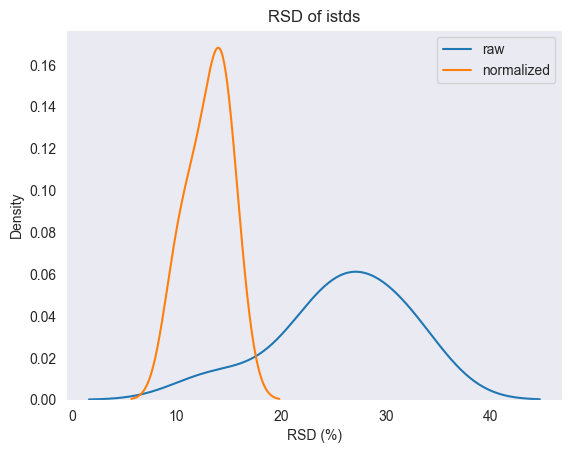

In [245]:
fig, ax = plt.subplots()
sns.kdeplot(cv_raw, label = 'raw')
sns.kdeplot(cv_normalized, label = 'normalized')
ax.legend()
ax.set_xlabel('RSD (%)')
ax.set_title('RSD of istds')
ax.grid(False)
plt.savefig(os.path.join(data_dir, 'istd_rsd.png'))

In [216]:
qc_cv_raw = []
qc_cv_normalized = []
for compound in compound_list:
    qc_cv_raw.append(calc_cv(data_working[qc_idx][compound]))
    qc_cv_normalized.append(calc_cv(data_normalized[qc_idx][compound]))

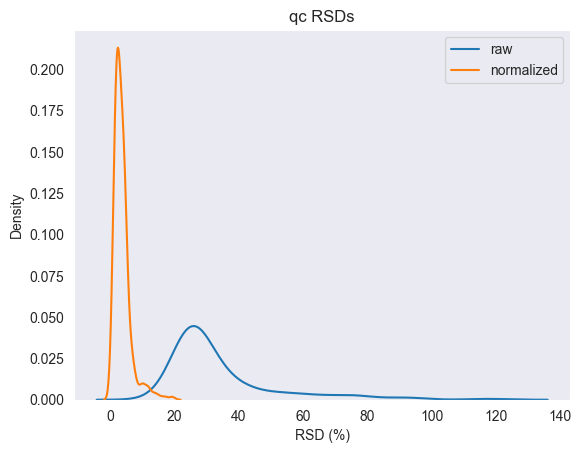

In [247]:
fig, ax = plt.subplots()
sns.kdeplot(qc_cv_raw, label = 'raw')
sns.kdeplot(qc_cv_normalized, label = 'normalized')
ax.legend()
ax.set_xlabel('RSD (%)')
ax.set_title('qc RSDs')
ax.grid(False)
plt.savefig(os.path.join(data_dir, 'qc_rsd.png'))

In [227]:
np.mean(qc_cv_raw)

33.79570895522388

In [228]:
np.mean(qc_cv_normalized)

3.6604850746268656

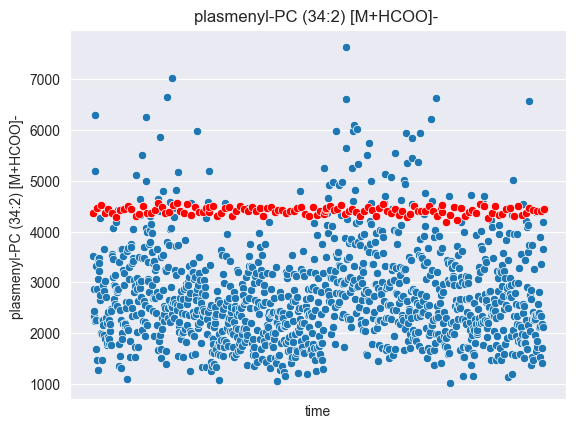

(36.09, 1.66)

In [263]:
cv_plot(data_normalized, compound_list[106], qc_idx= qc_idx)

(24.28, 24.2)

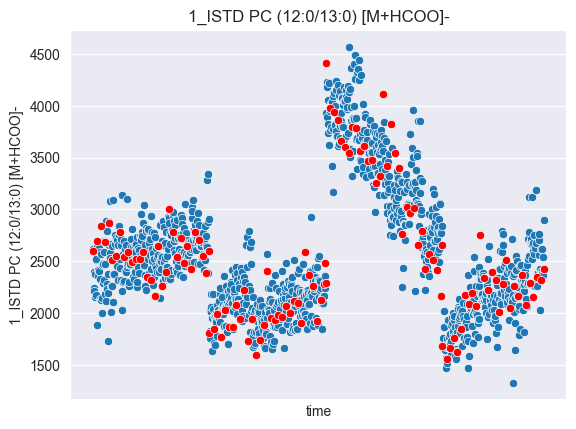

In [271]:
cv_plot(data_working, compound_list[5], qc_idx= qc_idx, savepath=os.path.join(data_dir, 'istd_raw.png'))

(12.21, 2.41)

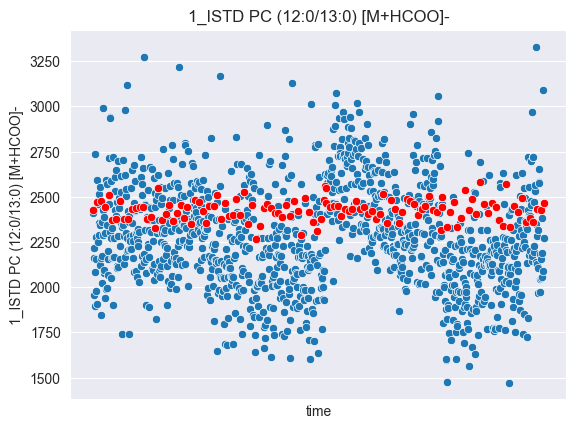

In [275]:
cv_plot(data_normalized, compound_list[5], qc_idx= qc_idx, savepath=os.path.join(data_dir, 'istd_normalized.png'))

(36.09, 1.66)

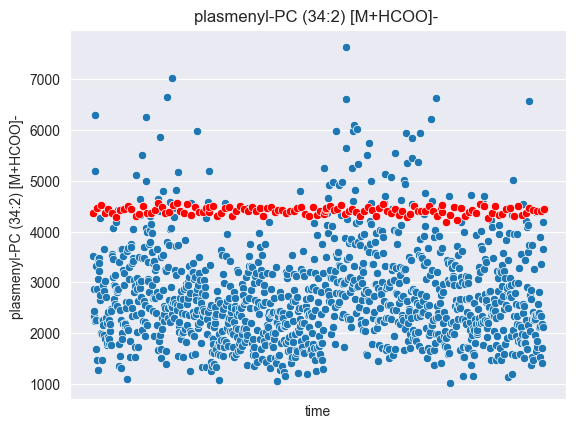

In [276]:
cv_plot(data_normalized, compound_list[106], qc_idx= qc_idx, savepath=os.path.join(data_dir, 'compound_normalized.png'))

(44.97, 23.97)

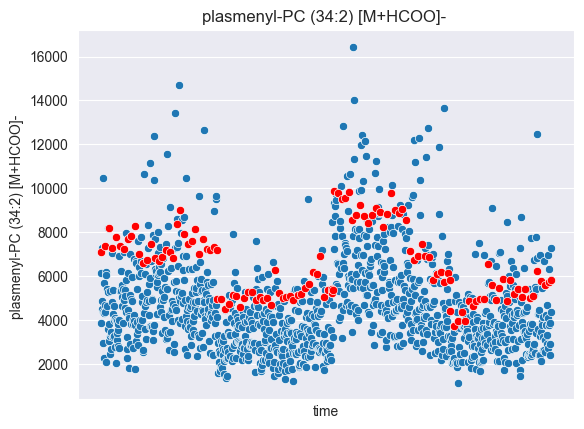

In [278]:
cv_plot(data_working, compound_list[106], qc_idx= qc_idx, savepath=os.path.join(data_dir, 'compound_raw.png'))

In [273]:
compound_list[106]

'plasmenyl-PC (34:2) [M+HCOO]- '